Importing libraries

In [200]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [201]:
#setup matplot's deafults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [202]:
#import data preprocessing libraries
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [203]:
#import feature engineering libraries
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.cluster import KMeans


In [204]:
#import model libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [205]:
#import metric evaliation libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve

In [206]:
import os

In [207]:
import warnings
warnings.filterwarnings('ignore')

Downloading data:
Data was downloaded using Kaggle Api
kaggle competitions download -c house-prices-advanced-regression-techniques
After that datasets where unzipped to further use

In [208]:
#loading train and test dataset
train = pd.read_csv('train.csv', index_col = 'Id')
test = pd.read_csv('test.csv', index_col = 'Id')

In [209]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

Data visualisation
The best way to get some insights of what is going on in a dataset is to make a data visualisation

In [210]:
train.shape


(1460, 80)

In [12]:
train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

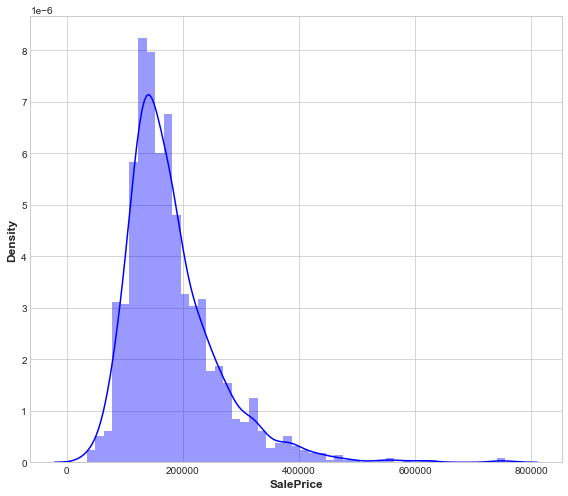

In [13]:
#Let's see how is SalePrice distributed
plt.figure(figsize = (8,7))
dist = sns.distplot(train['SalePrice'],color = 'blue',kde = True)

plt.show()

The distribution figure shows that SalePrice is not normaly distributed and will require further standardize.

Now lets see the correlation with each data and the SalePrice

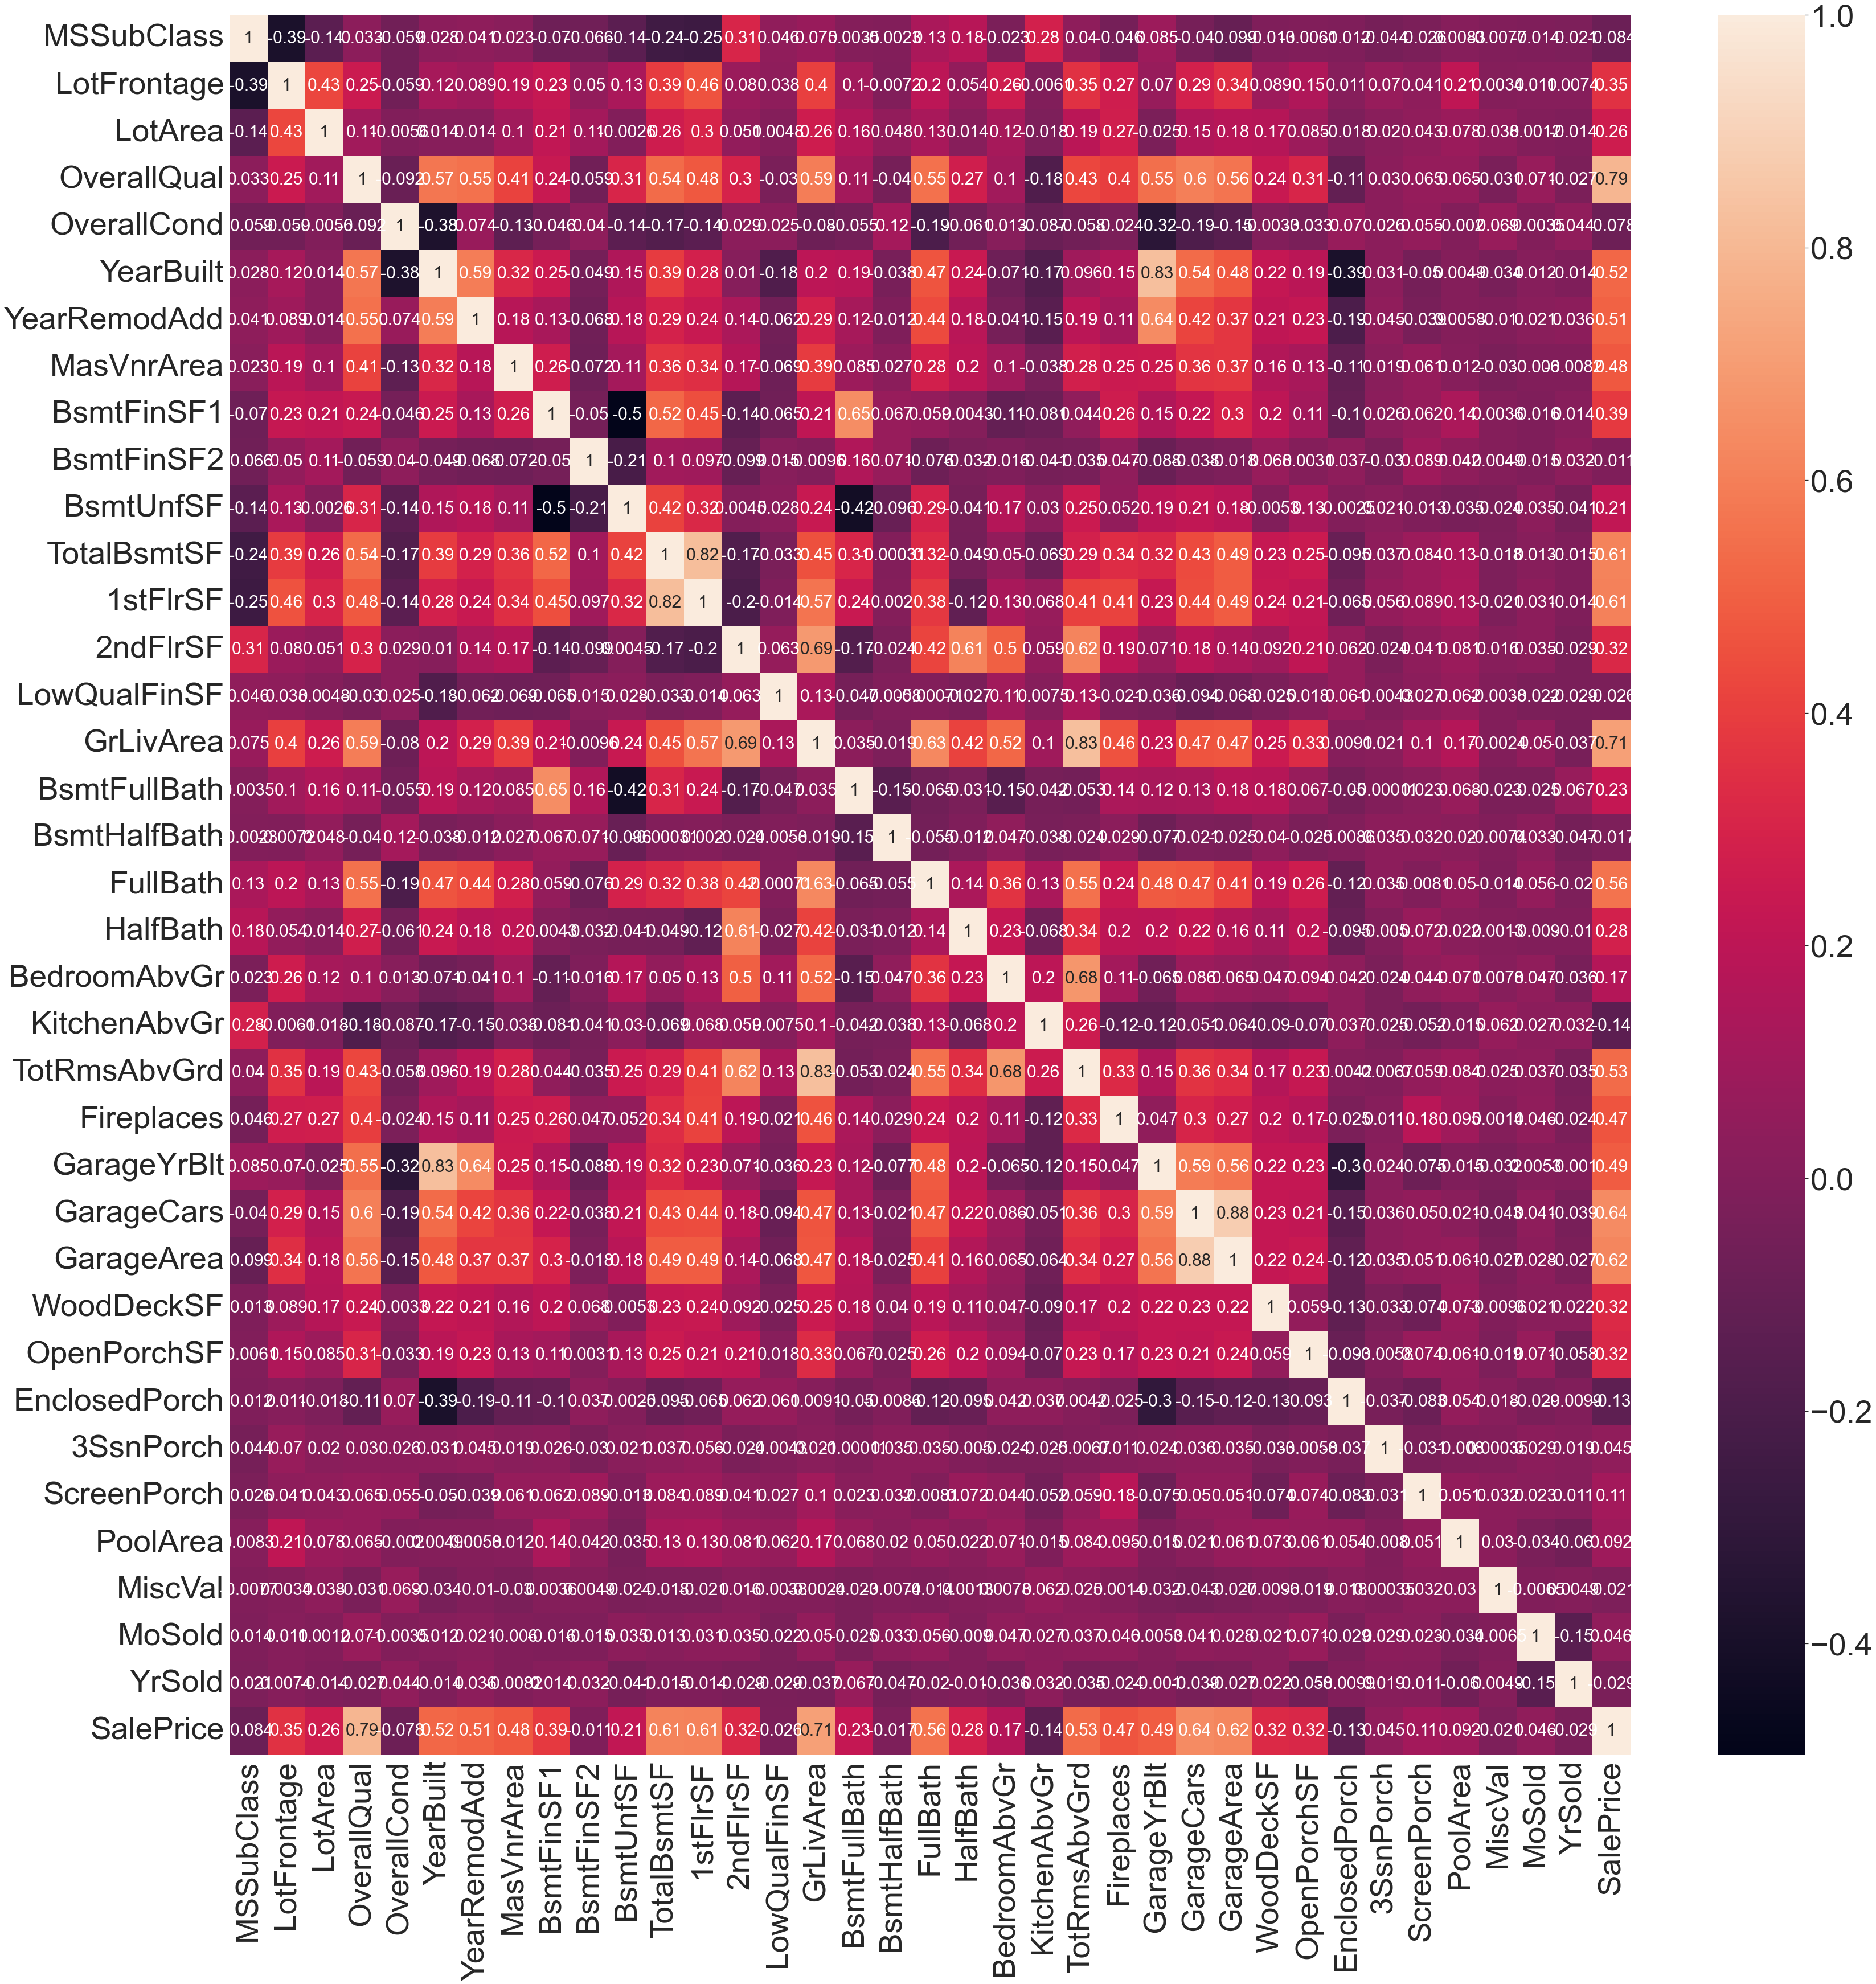

In [14]:
plt.figure(figsize = (50,50))

corr = train.corr()
sns.set(font_scale = 5)
sns.heatmap(corr,annot = True,annot_kws={"size": 30})
plt.show()


In [15]:
train.corr()['SalePrice'].sort_values(ascending=False)[1:11]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

10 Highest correlation with SalePrice:
1. OverallQual - 0.79 - Rates the overall material and finish of the house
2. GrLivArea - 0.71 - Above grade (ground) living area square feet
3. GarageCars - 0.64 - Size of garage in car capacity
4. GarageArea - 0.62 - Size of garage in square feet
5. Total BsmtSF  - 0.61 - Total square feet of basement area
6. 1stFlrSf - 0.61 - First Floor square feet
7. FullBath - 0.56 - Full bathrooms above grade
8. TotRmsAbvGrd - 0.53 - Total rooms above grade (does not include bathrooms)
9. YearBuild - 0.52 - Original construction date
10. YearRemodAdd - 0.51 - Remodel date (same as construction date if no remodeling or additions)

/In addition to above/
In the furher part of work, features like GarageCars & GarageArea that are highly correlated which each other,
will be careful examined in terms of feature engineering


Now lets plot those values in order to see if there are some obvious outliners

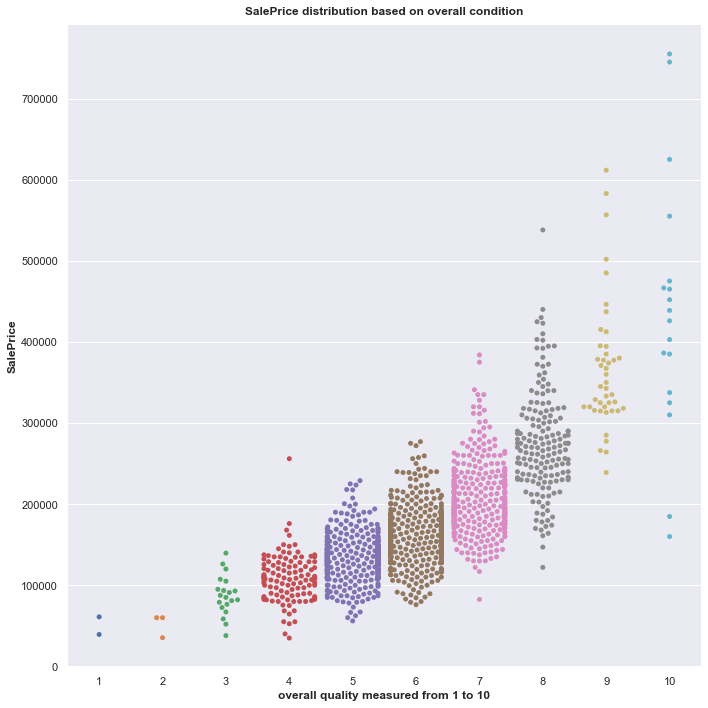

In [16]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
qual = sns.swarmplot(x = train['OverallQual'],y=train['SalePrice'])
qual.set(title = "SalePrice distribution based on overall condition",xlabel = 'overall quality measured from 1 to 10')
sns.despine()
plt.show()

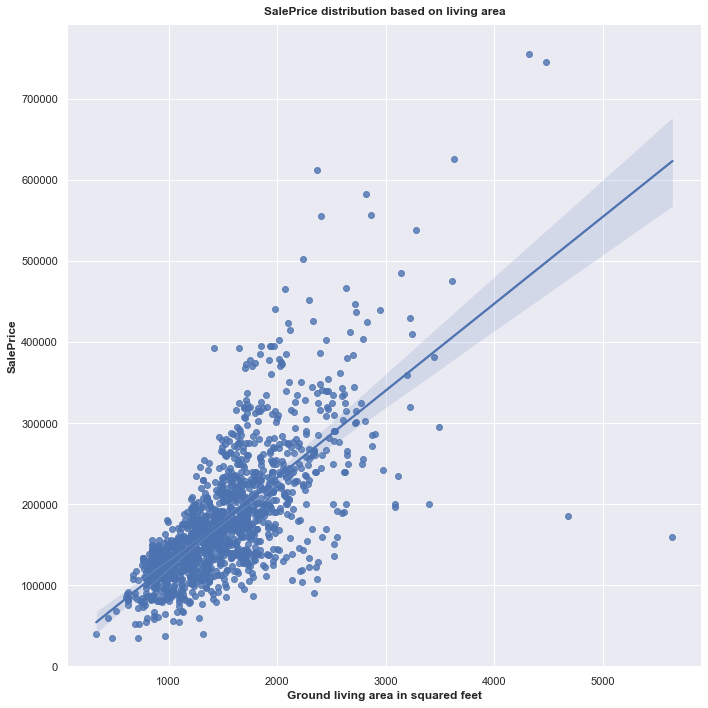

In [17]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
liv_area = sns.regplot(x = train['GrLivArea'], y = train['SalePrice'])
liv_area.set(title = 'SalePrice distribution based on living area',xlabel = 'Ground living area in squared feet')
sns.despine()
plt.show()

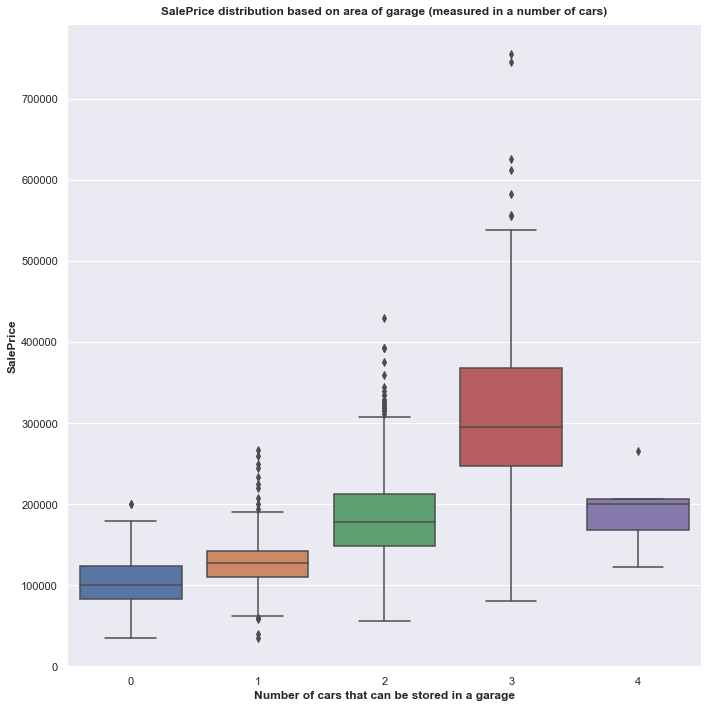

In [17]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
garage_cars = sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])
garage_cars.set(title = 'SalePrice distribution based on area of garage (measured in a number of cars)',xlabel = 'Number of cars that can be stored in a garage')
sns.despine()
plt.show()

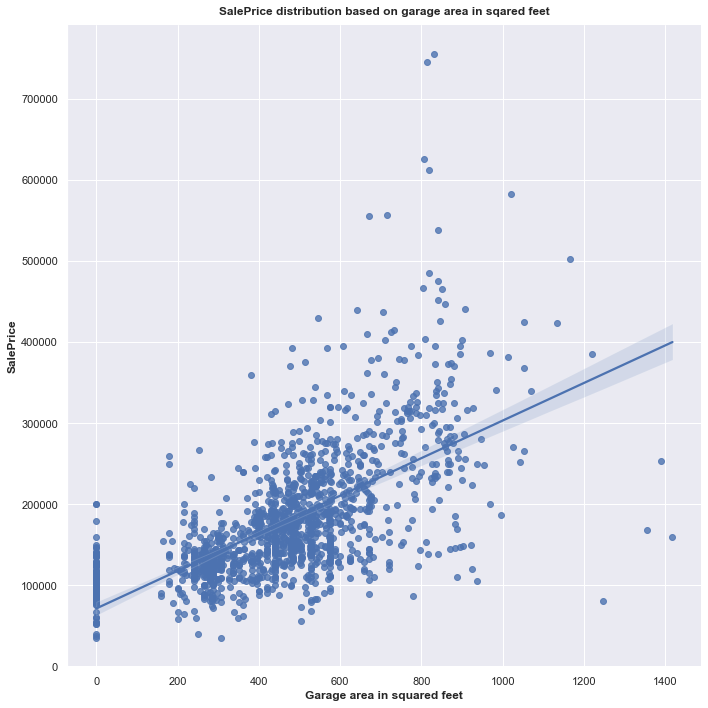

In [18]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
gar_area = sns.regplot(x = train['GarageArea'], y = train['SalePrice'])
gar_area.set(title = 'SalePrice distribution based on garage area in sqared feet',xlabel = 'Garage area in squared feet' )
sns.despine()
plt.show()

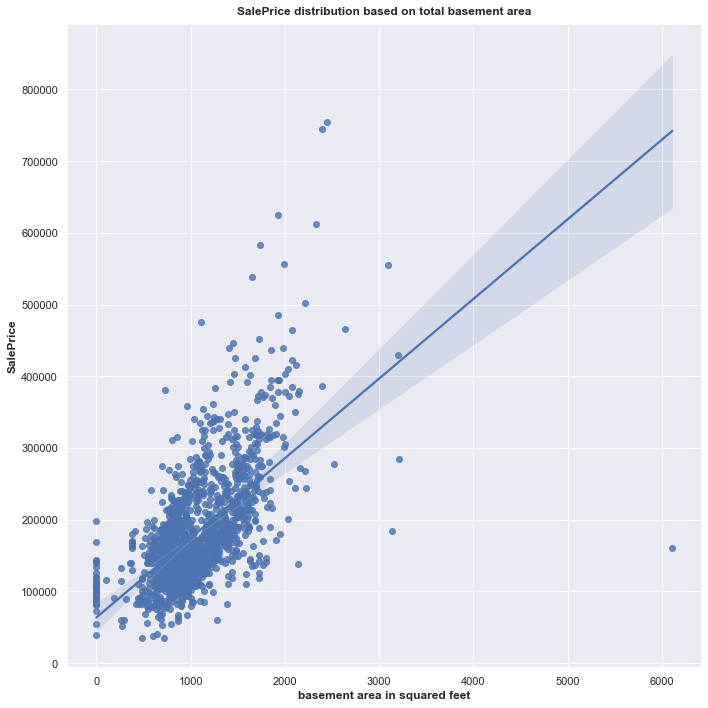

In [19]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
bsmt_area = sns.regplot(x = train['TotalBsmtSF'], y = train['SalePrice'])
bsmt_area.set(title = 'SalePrice distribution based on total basement area',xlabel = 'basement area in squared feet')
sns.despine()
plt.show()

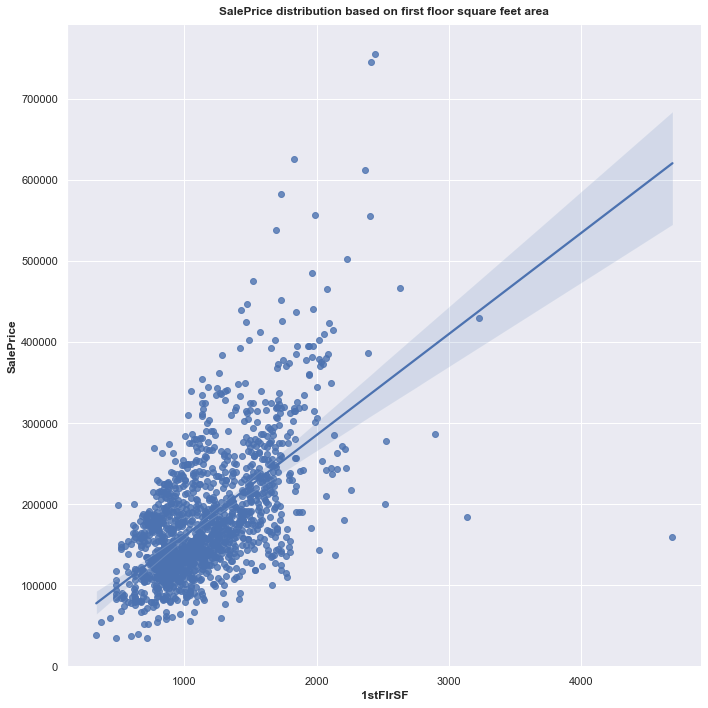

In [20]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
fst_area = sns.regplot(x = train['1stFlrSF'], y = train['SalePrice'])
fst_area.set(title = 'SalePrice distribution based on first floor square feet area')
sns.despine()
plt.show()

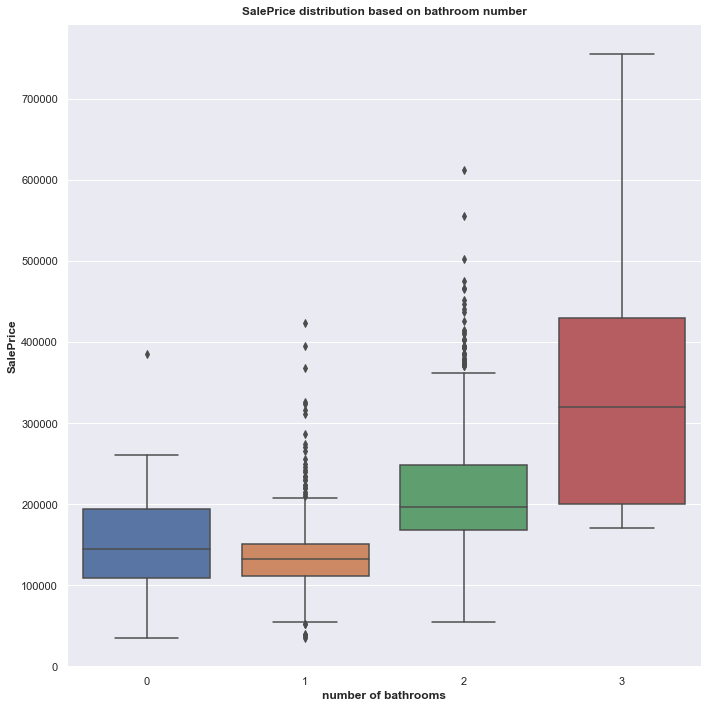

In [21]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
num_bath = sns.boxplot(x = train['FullBath'], y = train['SalePrice'])
num_bath.set(title = 'SalePrice distribution based on bathroom number',xlabel = 'number of bathrooms')
sns.despine()
plt.show()

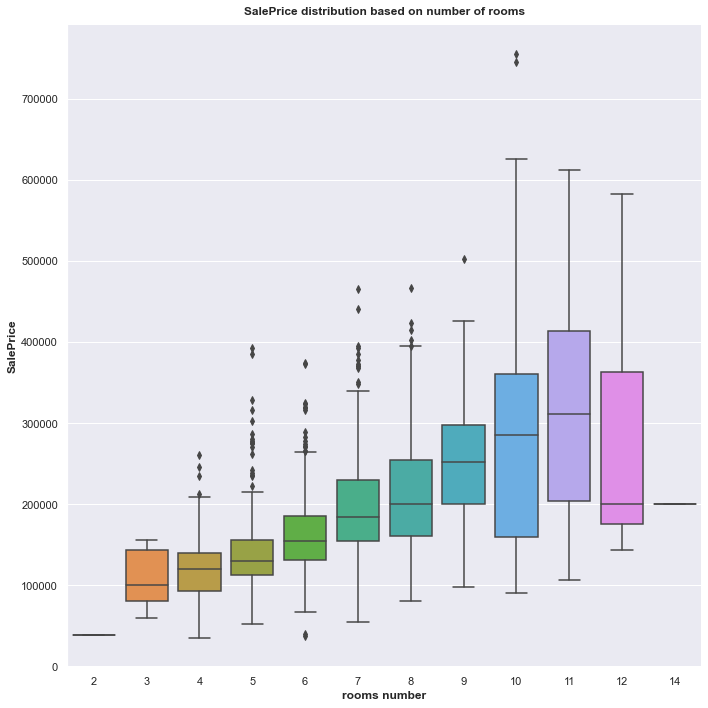

In [22]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
num_room = sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])
num_room.set(title = 'SalePrice distribution based on number of rooms',xlabel = 'rooms number')
sns.despine()
plt.show()

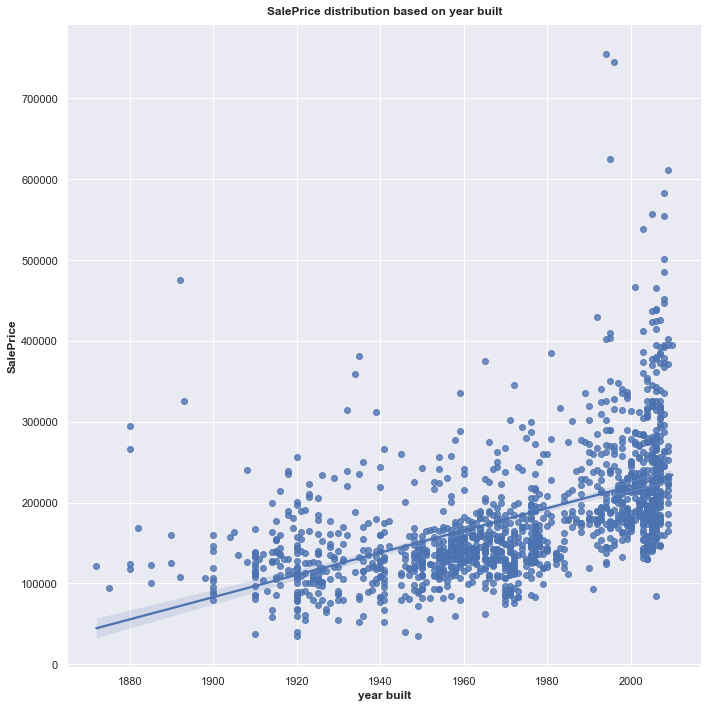

In [23]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
yr_built= sns.regplot(x = train['YearBuilt'], y = train['SalePrice'])
yr_built.set(title = 'SalePrice distribution based on year built',xlabel = 'year built')
sns.despine()
plt.show()

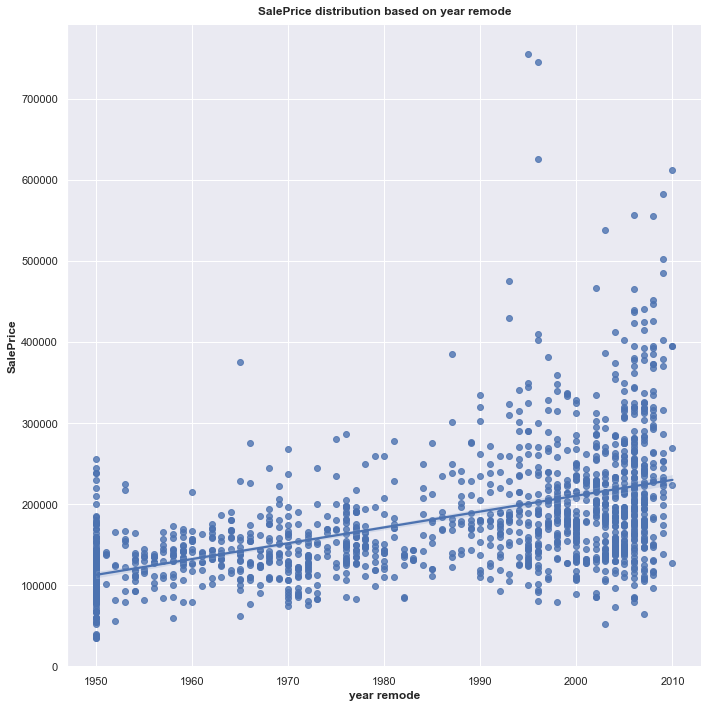

In [24]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
yr_remode= sns.regplot(x = train['YearRemodAdd'], y = train['SalePrice'])
yr_remode.set(title = 'SalePrice distribution based on year remode',xlabel = 'year remode')
sns.despine()
plt.show()

Lets investigate missing values

In [18]:
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending = False) #printing columns with missing values


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

First, lets consider those missing values which accualy are informative. According to data_description:
1. Nan in PoolQC means no pool
2. Nan in MiscFeatures means no miscellaneous feature
3. Nan in Alley means no alley acces
4. Nan in Fence means no fence
5. Nan in FireplaceQu means no fireplace

In [19]:
no_missing = train.copy()
no_missing.isnull().sum()[no_missing.isnull().sum()>0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [211]:
no_missing['PoolQC'] = no_missing['PoolQC'].fillna('None')
no_missing['MiscFeature'] = no_missing['MiscFeature'].fillna('None')
no_missing['Alley'] = no_missing['Alley'].fillna('None')
no_missing['Fence'] = no_missing['Fence'].fillna('None')
no_missing['FireplaceQu'] = no_missing['FireplaceQu'].fillna('None')

As we can see there are 81 missing values per garage's features which is connected with a non existance of a garage, 38 with a basement and 8 with a masonry veneer type

In [212]:
gar_cat_features = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
no_missing['GarageYrBlt'] =no_missing['GarageYrBlt'].astype(float) 
no_missing['GarageYrBlt'] = no_missing['GarageYrBlt'].fillna(0)
for fit in gar_cat_features:
    no_missing[fit] = no_missing[fit].fillna('None')

As far as Lot Frontage is considered, lets examine it's correlation to find out what would be the most suitale way of filling missing values

In [213]:
no_missing.corr()['LotFrontage'].sort_values(ascending = False)[1:5]
#It shows features that might be helpful in filling missing valuses, but lets also consider categorical feature: neighbrhood

SalePrice      0.375594
1stFlrSF       0.375570
GrLivArea      0.350236
TotalBsmtSF    0.329766
Name: LotFrontage, dtype: float64

In [214]:
no_missing[['LotArea','LotFrontage','1stFlrSF','GrLivArea','Neighborhood']].sort_values(by = '1stFlrSF').head(20)
#while sorting by each of this features it appeared that the appropriate way is to fill missing values based on neighbor hood

LotArea  LotFrontage  1stFlrSF  GrLivArea Neighborhood
Id                                                          
534      5000         50.0       334        334      BrkSide
706      5600         70.0       372       1092       IDOTRR
1101     8400         60.0       438        438        SWISU
917      9000         50.0       480        480       IDOTRR
431      1680         21.0       483        987       BrDale
838      1680         21.0       483        987       BrDale
236      1680         21.0       483        987       BrDale
1379     1953         21.0       483        987       BrDale
233      1680         21.0       483        987       BrDale
228      1869         21.0       483        987       BrDale
364      1680         21.0       483        987       BrDale
363      7301         64.0       495       1922      Edwards
126      6780         60.0       520        754       IDOTRR
30       6324         60.0       520        520      BrkSide
832      3180         30.0       520       1200      Somerst
1365     3180         30.0       520       1200      Somerst
830      2544         24.0       520       1223      Somerst
656      1680         21.0       525       1092       BrDale
76       1596         21.0       526        988      MeadowV
345      2592         36.0       536       1112      MeadowV

In [215]:
#Filling LotFrontage values with a mean of LotFrontage in a particular neighborhoods
no_missing['LotFrontage'] = no_missing.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [216]:
#Lack of values in basement features means there is no basement so it will be filled with None
bsmt_features = ['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']
for feature in bsmt_features:
    no_missing[feature] = no_missing[feature].fillna("None")

In [217]:
#Lack of values in Masonry veneer features will be filled with "0" for area and "None" for type
no_missing['MasVnrType'] = no_missing['MasVnrType'].fillna('None')
no_missing['MasVnrArea'] = no_missing['MasVnrArea'].fillna(0)

In [218]:
#With the electrical column it will be used to filled with  a most common value
no_missing.groupby('Electrical').count()
no_missing['Electrical'] = no_missing['Electrical'].fillna('SBrkr')

In [219]:
no_missing.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscFeature      0
MiscVal          0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 78, dtype: int64

Having filled missing values the next step is feature engineering

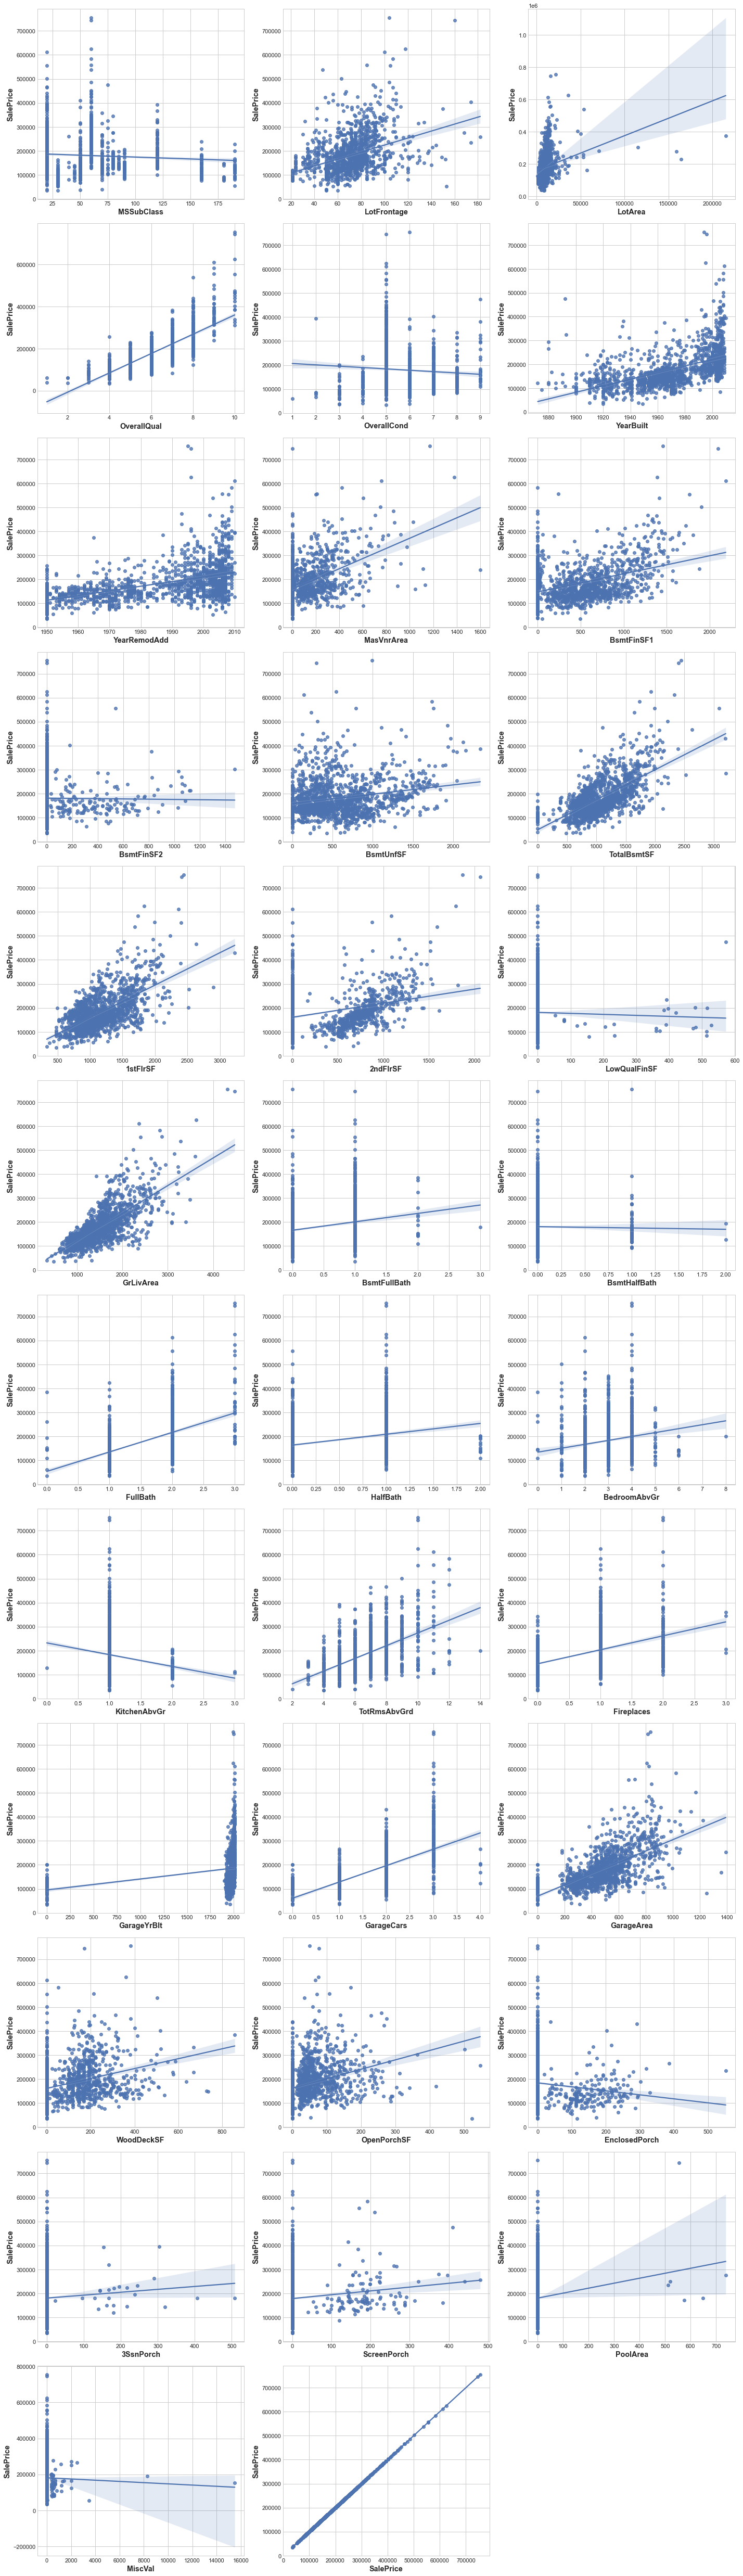

In [220]:
#Firstly lets remove outliars, to achieve this lets make a look on num variables again.
num_col = [col for col in no_missing.columns if no_missing[col].dtype != 'object'] #here are numerical columns
#now lets make a big suplot of those columns
fig, axs = plt.subplots(figsize=(20, 200)) #make a big figure for  subplots
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(num_col, 1):
    plt.subplot(len(num_col), 3, i)
    regs = sns.regplot(x=no_missing[feature], y=no_missing['SalePrice'])      
        
plt.show()

As we can see there are some outliers:
1. LotFrontage > 300 & SalePrice < 300000
2. BsmnFinSF1 > 5000 & SalePrice < 200000
3. TotalBsmtSF > 6000 & SalePrice < 200000
4. GrLivArea > 4000 & SalePrice <20000

In [221]:
no_missing = no_missing.drop(no_missing[(no_missing['GrLivArea']>4000) & (train['SalePrice']<200000)].index)
no_missing = no_missing.drop(no_missing[(no_missing['LotFrontage']>300) & (no_missing['SalePrice']<300000)].index)

The second important thing that comes with regplots is the fact that MoSold and YrSold doesnt have an impact on SalePrice so those features should be deleted

In [222]:
#no_missing = no_missing.drop(['MoSold','YrSold'],axis = 1)
#num_col.remove('YrSold')
#num_col.remove('MoSold')

KeyError: "['MoSold' 'YrSold'] not found in axis"

In [223]:
X = no_missing.copy()
y = X.SalePrice
X = X.drop(['SalePrice'],axis = 1)

In [226]:
num_col.remove('SalePrice')

In [204]:
discrete_features = X[num_col].dtypes == int

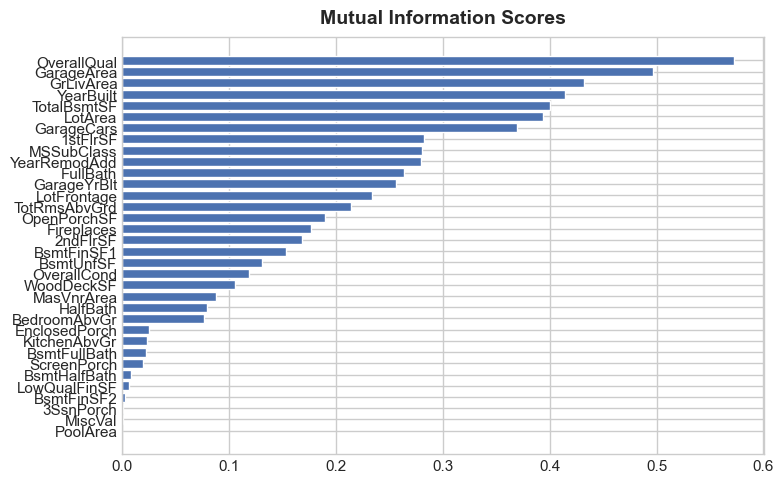

In [227]:
def mi_scores(x,y,discrete_features):
  mi_score = mutual_info_regression(x,y,discrete_features = discrete_features)
  mi_score = pd.Series(mi_score,name = 'MI scores',index = x.columns)
  mi_score = mi_score.sort_values(ascending = False)
  return mi_score

mi_scores(X[num_col],y,discrete_features)
#teraz czas na splotowanie wykresu dla lepszej analizy
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores(X[num_col],y,discrete_features))

Looking for outliar using PCA method

Standardize distribution of numerical variables

Categorical data encoding

In [228]:
#making a list of a categorical data columns
cat_col = [col for col in no_missing.columns if no_missing[col].dtype == 'object']
rep_col = []
for i, col in enumerate(no_missing.columns, 1): #check wheter there are no repetitions
    if col in cat_col and col in num_col:
        rep_col.append(col)
    else:
        rep_col.append(i)
print(rep_col)   


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]


In [229]:
#lets devide categorical that suit for LabelEncodin (connected with quality) and OGetting dummies
OneHotEnc = []
LabelEnc = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
           'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','Fence',]
for col in cat_col:
    if col not in LabelEnc:
        OneHotEnc.append(col)
#Now we can encode columns with a chosen methods
#LabelEncoding --> for those features that comes with an intuition of ordering by numbers eq. quality: good-ok-bad
label_encoding = no_missing[LabelEnc].copy()
for colname in label_encoding[LabelEnc]:
    label_encoding[colname], _ = label_encoding[colname].factorize()
#Getting dummies
dummy = no_missing[OneHotEnc].copy()
dummy = pd.get_dummies(dummy[OneHotEnc])
#joining dummies + label encoding + numerical features
numerical = no_missing.copy()
num = numerical[num_col]
train_encoded = pd.concat([num,label_encoding,dummy],axis = 1)
train_encoded.dropna(axis = 0, inplace = True)
train_encoded



MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
Id                                                      ...                   
1             2003       196.0         706           0  ...               0   
2             1976         0.0         978           0  ...               0   
3             2002       162.0         486           0  ...               0   
4             1970         0.0         216           0  ...               0   
5             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1456          2000         0.0           0           0  ...               0   
1457          1988       119.0         790         163  ...               0   
1458          2006         0.0         275           0  ...               0   
1459          1996         0.0          49        1029  ...               0   
1460          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      1   
5                0             0            1                      0   
...            ...           ...          ...                    ...   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   
1460             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
5                         0                     0                     0   
...                     ...                   ...                   ...   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   
1460                      0                     0                     0   

      SaleCondition_Normal  SaleCondi

In [231]:
y

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1457, dtype: int64

In [232]:
x = train_encoded.copy()

#num_col.remove('SalePrice')

In [233]:
x

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
Id                                                      ...                   
1             2003       196.0         706           0  ...               0   
2             1976         0.0         978           0  ...               0   
3             2002       162.0         486           0  ...               0   
4             1970         0.0         216           0  ...               0   
5             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1456          2000         0.0           0           0  ...               0   
1457          1988       119.0         790         163  ...               0   
1458          2006         0.0         275           0  ...               0   
1459          1996         0.0          49        1029  ...               0   
1460          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      1   
5                0             0            1                      0   
...            ...           ...          ...                    ...   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   
1460             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
5                         0                     0                     0   
...                     ...                   ...                   ...   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   
1460                      0                     0                     0   

      SaleCondition_Normal  SaleCondi

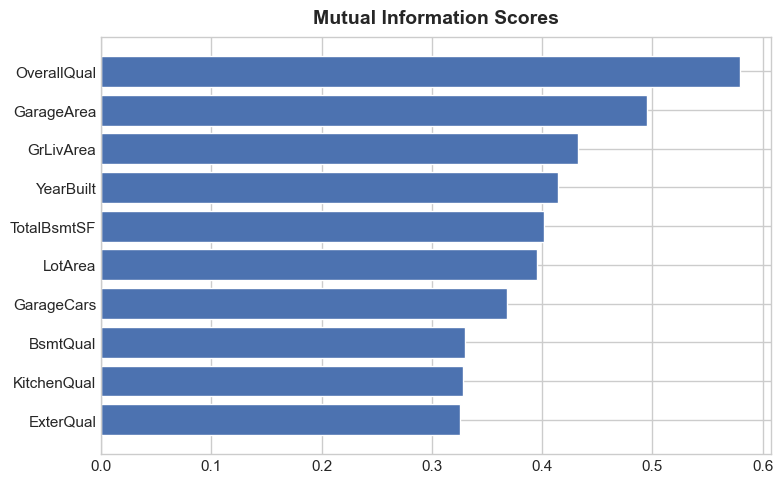

In [234]:
#Lets take a look on a cleared and encoded data in order to find some new correlation
discrete_features = x[num_col].dtypes == int
def mi_scores(x,y,discrete_features):
  mi_score = mutual_info_regression(x,y,discrete_features = discrete_features)
  mi_score = pd.Series(mi_score,name = 'MI scores',index = x.columns)
  mi_score = mi_score.sort_values(ascending = False)
  return mi_score


#For visualisation we can plot 10 best correlations
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores(x,y,discrete_features_all)[:10])

In [235]:
discrete_features_all = x.dtypes == int
mi_scores(x,y,discrete_features_all)[:10]

OverallQual    0.576543
GarageArea     0.493308
GrLivArea      0.432043
YearBuilt      0.414311
TotalBsmtSF    0.396695
LotArea        0.391254
GarageCars     0.366929
ExterQual      0.330552
KitchenQual    0.329643
BsmtQual       0.328977
Name: MI scores, dtype: float64

In [236]:
#now lets investigate data using PCA
pca_train = x.copy()
#outliers = [313, 249, 335, 705, 451, 457, 384, 1393, 847, 768]
#pca_train = pca_train.drop(pca_train.index[outliers])
#y = y.drop(y.index[outliers])
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [237]:
#lets use best ratings from mutual information to check PCA
mi_features = ['OverallQual','GarageArea','GrLivArea','YearBuilt','TotalBsmtSF','LotArea','GarageCars','KitchenQual',
               'BsmtQual','ExterQual']
pca_train = pca_train.loc[:,mi_features]


pca, X_pca, loadings = apply_pca(pca_train)
print(loadings)

                  PC1       PC2       PC3       PC4       PC5       PC6  \
OverallQual -0.407384  0.086908 -0.098358 -0.127720 -0.343778 -0.144245   
GarageArea  -0.397062  0.231971 -0.224185  0.195593  0.356064  0.227471   
GrLivArea   -0.308363  0.292707  0.145142  0.169511 -0.649845  0.334209   
YearBuilt   -0.362092 -0.208654 -0.170732 -0.298683  0.280834 -0.260429   
TotalBsmtSF -0.325495  0.217472  0.140750 -0.478754 -0.068271 -0.401462   
LotArea     -0.104180  0.280313  0.834440  0.170709  0.320786 -0.137021   
GarageCars  -0.415067  0.178442 -0.221577  0.189358  0.321959  0.247077   
KitchenQual  0.217164  0.493379 -0.129641 -0.477398 -0.011024  0.042631   
BsmtQual     0.183864  0.468585 -0.322200  0.484680 -0.040239 -0.613661   
ExterQual    0.283081  0.434416 -0.063511 -0.265441  0.202253  0.358527   

                  PC7       PC8       PC9      PC10  
OverallQual  0.206997  0.321322  0.716795 -0.040225  
GarageArea  -0.096317 -0.209547  0.050291 -0.682477  
GrLivArea   

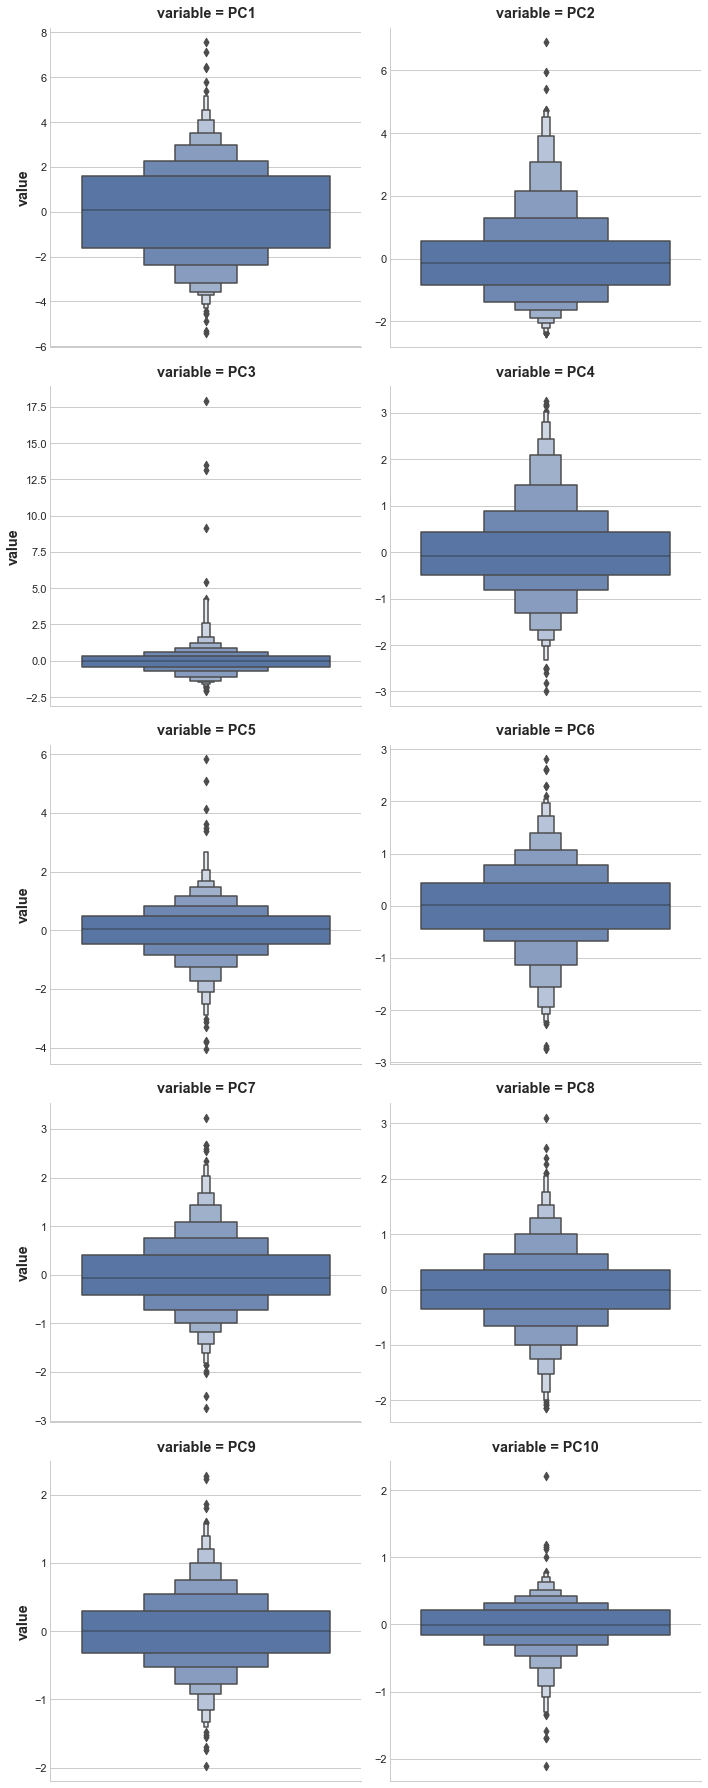

In [238]:
#PCA is a great tool to find outliars, first lets plot the distributions of the components
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [173]:
#As we can see there are some outliers in every variable so lets note down thier index value

component = "PC1"# name of the component
idx = X_pca[component].sort_values(ascending=False).index
#print(idx[:10])
pca_train.loc[idx[:10], mi_features] #dataframe of chosen indexes
id_pc1 = [532,375,635,704,1320,1180,1167]
id_pc2 = [313,690,335,]
id_pc3 = [313,249,335,705,451]
id_pc5 = [313,335,1059,249,1188,1180,1346,634]
id_pc6 = [1059,1255,313]
id_pc7 = [313,332,496]
id_pc9 = [582,989]
id_pc10 = [1337,643,268,580]
outliers_id = []
id_list = [id_pc1,id_pc2,id_pc3,id_pc5,id_pc6,id_pc7,id_pc9,id_pc10]
for lst in id_list: #loop that check reapeting indexes and making a final outliers_id list
    for i in lst:
        if i not in outliers_id:
            outliers_id.append(i)
print(outliers_id)


[532, 375, 635, 704, 1320, 1180, 1167, 313, 690, 335, 249, 705, 451, 1059, 1188, 1346, 634, 1255, 332, 496, 582, 989, 1337, 643, 268, 580]


In [172]:
X_pca['PC10'].sort_values(ascending = False)

1337    2.211825
643     1.178525
456     1.148010
420     1.126541
746     1.009066
          ...   
899    -1.350730
900    -1.587158
944    -1.688945
580    -1.693942
268    -2.111544
Name: PC10, Length: 1457, dtype: float64

In [199]:
X_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.577509 -1.624908  0.020350  0.476928 -0.231807 -0.330334  0.447477   
1    -0.068569 -0.040207 -0.062302 -1.139701  0.533008 -0.369696 -0.206144   
2    -1.856803 -1.269061  0.410225  0.539775 -0.037597 -0.266989  0.473806   
3    -0.546478  0.717734 -0.238342  1.813365  0.126650 -1.158514 -1.207385   
4    -3.704496 -0.219334  0.366651  0.855301  0.124320 -0.663475  0.280709   
...        ...       ...       ...       ...       ...       ...       ...   
1400 -0.294560 -0.274194 -0.332568 -0.797972  0.133834 -1.003699  0.180488   
1401 -1.028832  0.827040  0.875563 -1.080886 -0.151729 -0.491118 -0.480900   
1402  0.835603  0.944181  0.872984 -0.032961 -1.661650 -0.633713 -2.341863   
1403  1.721906 -0.673922  0.631904  0.103170  0.213223  0.806199 -1.048199   
1404  1.001629 -0.632972  0.563484 -0.321189 -0.433368  1.314761  0.693056   

           PC8       PC9      PC10  
0     0.271748  0.059143  0.166422  
1    -0.207154 -0.134942 -0.276763  
2     0.232755  0.040301  0.354408  
3    -0.527718 -1.413910 -0.637899  
4    -0.064738 -0.215345  0.143485  
...        ...       ...       ...  
1400  0.447538  0.546374 -0.180150  
1401 -0.191559  0.666428 -0.153124  
1402  1.545815 -0.126703  0.027683  
1403  0.277964 -0.117246 -0.108694  
1404 -0.842739  0.474160  0.004665  

[1405 rows x 10 columns]

In [177]:
# droping outliers
cleared_pca = x.copy()
cleared_pca = cleared_pca.drop(cleared_pca.index[outliers_id])

In [176]:
train_encoded['SalePrice']

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1457, dtype: int64

In [178]:
cleared_pca

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
Id                                                      ...                   
1             2003       196.0         706           0  ...               0   
2             1976         0.0         978           0  ...               0   
3             2002       162.0         486           0  ...               0   
4             1970         0.0         216           0  ...               0   
5             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1456          2000         0.0           0           0  ...               0   
1457          1988       119.0         790         163  ...               0   
1458          2006         0.0         275           0  ...               0   
1459          1996         0.0          49        1029  ...               0   
1460          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      1   
5                0             0            1                      0   
...            ...           ...          ...                    ...   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   
1460             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
5                         0                     0                     0   
...                     ...                   ...                   ...   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   
1460                      0                     0                     0   

      SaleCondition_Normal  SaleCondi

In [179]:
cleared_pca = cleared_pca.loc[:,mi_features]


pca, X_pca, loadings = apply_pca(cleared_pca)
print(loadings)

                  PC1       PC2       PC3       PC4       PC5       PC6  \
OverallQual -0.405530  0.049772 -0.131520 -0.113481 -0.423654  0.027881   
GarageArea  -0.401842  0.210796 -0.269356  0.176950  0.339330 -0.171649   
GrLivArea   -0.314555  0.275067  0.267860  0.218572 -0.593739 -0.336958   
YearBuilt   -0.359725 -0.237224 -0.237786 -0.272029  0.181807  0.104870   
TotalBsmtSF -0.320408  0.185666  0.083155 -0.524829 -0.062284  0.550181   
LotArea     -0.154863  0.382777  0.714655  0.085794  0.391851  0.145358   
GarageCars  -0.416007  0.160173 -0.267775  0.176647  0.299783 -0.237430   
KitchenQual  0.202224  0.478638 -0.185976 -0.465770 -0.133679 -0.206789   
BsmtQual     0.173856  0.455025 -0.377928  0.478659 -0.115091  0.573227   
ExterQual    0.273668  0.422330 -0.122850 -0.271976  0.203423 -0.306054   

                  PC7       PC8       PC9      PC10  
OverallQual  0.081712  0.343387 -0.704328  0.044310  
GarageArea  -0.067961 -0.258802 -0.033649  0.687668  
GrLivArea   

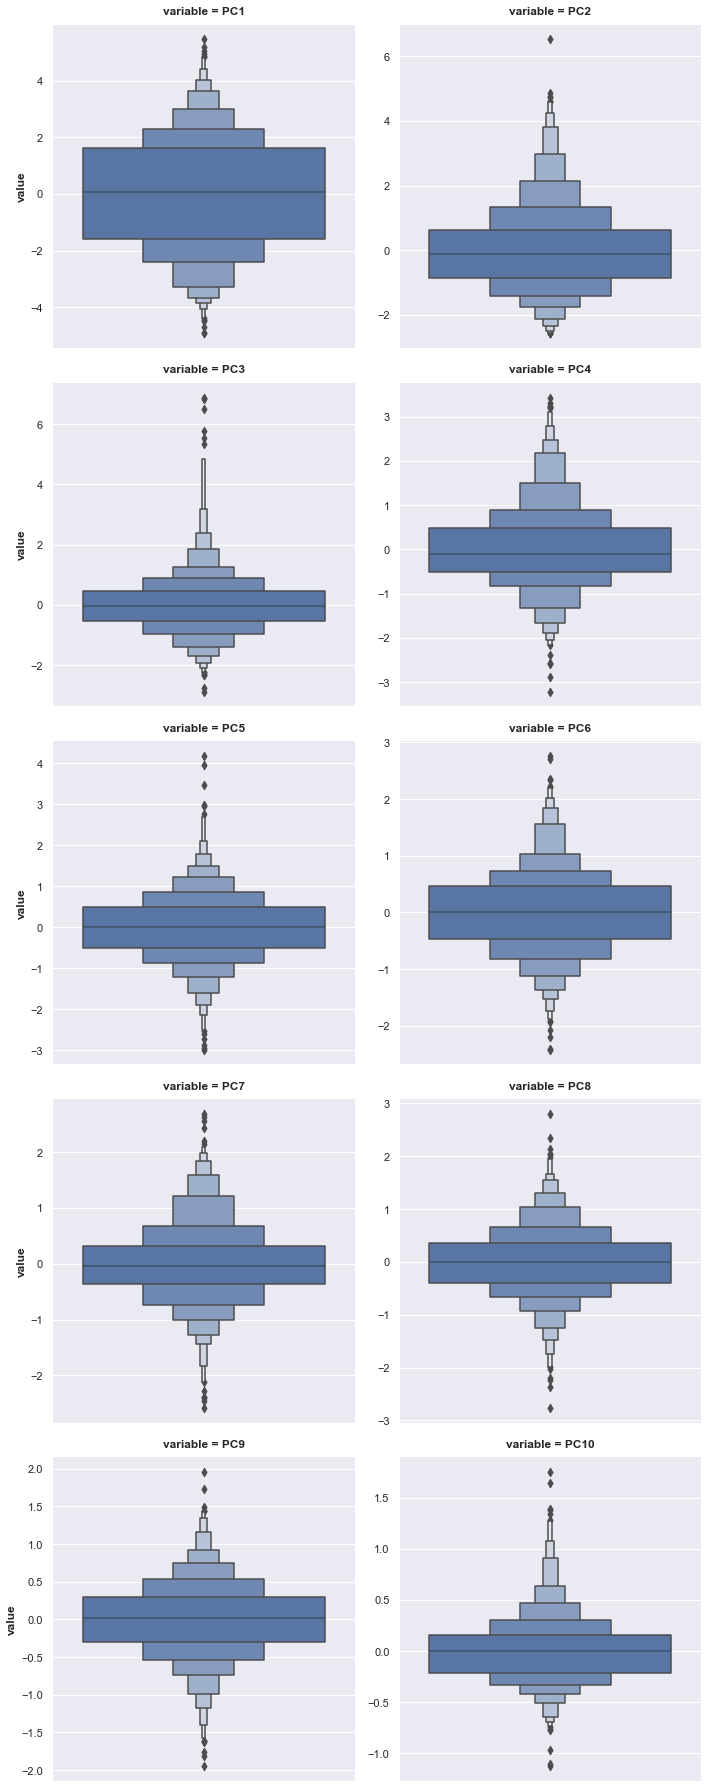

In [180]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [185]:
pca_y = train_encoded['SalePrice']
pca_y = pca_y.drop(pca_y.index[outliers_id])
pca_y

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1431, dtype: int64

In [ ]:
#Distributions looks better now so lets concate PCA df with encoded one

In [187]:
X_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.583560 -1.605210  0.021678  0.482396 -0.233094 -0.361489  0.421905   
1    -0.064491 -0.034642 -0.044199 -1.146816  0.522153 -0.359619 -0.236467   
2    -1.862176 -1.244621  0.407593  0.549586 -0.033199 -0.303129  0.450853   
3    -0.538720  0.737885 -0.287869  1.810403  0.127160 -1.082626 -1.289547   
4    -3.703540 -0.183894  0.349639  0.851994  0.124681 -0.690033  0.232069   
...        ...       ...       ...       ...       ...       ...       ...   
1426 -0.290855 -0.269344 -0.315758 -0.806416  0.110914 -1.017996  0.117365   
1427 -1.023118  0.847272  0.894014 -1.073362 -0.156329 -0.460081 -0.515881   
1428  0.841078  0.961057  0.877145  0.013472 -1.666391 -0.476431 -2.384748   
1429  1.716785 -0.661634  0.626814  0.127947  0.231859  0.871153 -1.001886   
1430  0.997095 -0.619435  0.580608 -0.306658 -0.409380  1.278936  0.770492   

           PC8       PC9      PC10  
0     0.263192  0.068629  0.164083  
1    -0.196061 -0.143431 -0.278267  
2     0.224869  0.050200  0.351838  
3    -0.524170 -1.401660 -0.637858  
4    -0.071109 -0.204915  0.140480  
...        ...       ...       ...  
1426  0.444432  0.546714 -0.184183  
1427 -0.195895  0.663294 -0.156042  
1428  1.534719 -0.086697  0.031585  
1429  0.282209 -0.106471 -0.107540  
1430 -0.844484  0.454703  0.003761  

[1431 rows x 10 columns]

In [240]:
X_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.606501 -1.531445 -0.075290  0.379902 -0.197775  0.191044  0.593744   
1    -0.079257 -0.059647  0.054191 -1.079312  0.534352  0.416496 -0.228373   
2    -1.820695 -1.295061  0.153236  0.454997 -0.132360  0.221728  0.522723   
3    -0.517607  0.690678 -0.388983  1.814315 -0.077192  1.395709 -0.888949   
4    -3.544927 -0.296109 -0.000797  0.765607 -0.044414  0.712045  0.361500   
...        ...       ...       ...       ...       ...       ...       ...   
1452 -0.328585 -0.206468 -0.213147 -0.850901  0.251601  0.793907  0.497535   
1453 -0.927928  0.686142  0.630195 -1.052654 -0.347409  0.655201 -0.449025   
1454  0.821036  0.917256  0.627415 -0.029571 -1.877261  0.751699 -1.494512   
1455  1.650901 -0.788940  0.514265  0.194729 -0.017979 -0.522834 -1.148009   
1456  0.967895 -0.709195  0.448294 -0.276540 -0.436415 -1.236614  0.129924   

           PC8       PC9      PC10  
0     0.211951 -0.083670 -0.171134  
1    -0.136914  0.166172  0.285837  
2     0.127989 -0.103957 -0.355141  
3    -0.061088  1.376969  0.681188  
4    -0.083350  0.137280 -0.131641  
...        ...       ...       ...  
1452  0.446314 -0.490242  0.182652  
1453 -0.113914 -0.651375  0.158811  
1454  2.038822  0.123797  0.003208  
1455  0.433518  0.060675  0.109300  
1456 -1.088320 -0.469539 -0.036440  

[1457 rows x 10 columns]

In [239]:
x

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
Id                                                      ...                   
1             2003       196.0         706           0  ...               0   
2             1976         0.0         978           0  ...               0   
3             2002       162.0         486           0  ...               0   
4             1970         0.0         216           0  ...               0   
5             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1456          2000         0.0           0           0  ...               0   
1457          1988       119.0         790         163  ...               0   
1458          2006         0.0         275           0  ...               0   
1459          1996         0.0          49        1029  ...               0   
1460          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      1   
5                0             0            1                      0   
...            ...           ...          ...                    ...   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   
1460             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
5                         0                     0                     0   
...                     ...                   ...                   ...   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   
1460                      0                     0                     0   

      SaleCondition_Normal  SaleCondi

In [ ]:
full